In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import numpy as np

from torchvision import datasets
from torch.utils.data import DataLoader


In [3]:
style_img_name = "datasets/lab9/style/picasso.jpg"
content_img_name = "datasets/lab9/content/Tuebingen_Neckarfront.jpg"

In [4]:
style_img = Image.open(style_img_name)
content_img = Image.open(content_img_name)

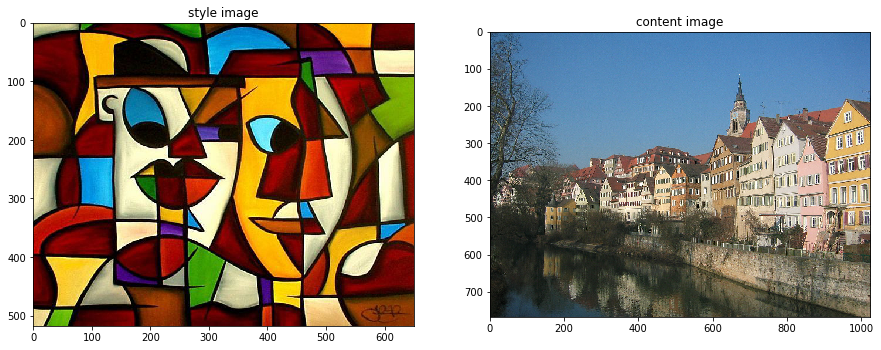

In [5]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,2,2)
plt.title('content image')
plt.imshow(content_img)

In [6]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [7]:
import torchvision.models.vgg as vgg

class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork, self).__init__()
        # get vgg network
        self.vgg_layers = vgg.vgg19(pretrained=True).features


    def forward(self, x, layer_name):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in layer_name:
                output[layer_name[name]] = x
        return output

In [8]:
loss_net = LossNetwork().cuda()
for param in loss_net.parameters():
    param.requires_grad = False

In [9]:
loss_net

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReL

In [10]:
style_layer_name = {
    '1': "conv1-1",
    '6': "conv2-1",
    '11': "conv3-1",
    '20': "conv4-1",
    '29': "conv5-1"
}

content_layer_name = {
    '22': "conv4-2"
}

In [7]:

img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                        std=[1,1,1]),
])

post = transforms.Compose([
    transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                        std=[1,1,1]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

In [12]:
content = prep(content_img).cuda().unsqueeze(0)
style = prep(style_img).cuda().unsqueeze(0)

out_img = content.clone()
out_img.requires_grad = True


criterion = nn.MSELoss()
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]
content_gt = [A.detach() for A in loss_net(content, content_layer_name).values()]

show_iter = 50
optimizer = optim.LBFGS([out_img])
n_iter = [0]

In [19]:
alpha = 1e0
beta = 1e7
max_iter = 500

In [20]:
while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        
        style_layers = [gram_matrix(f) for f in loss_net(out_img, style_layer_name).values()]
        content_layers = [f for f in loss_net(out_img, content_layer_name).values()]
        
        style_loss = 0
        for i in range(len(style_layers)):    
            style_loss += criterion(style_layers[i], style_gt[i])
        
        content_loss = criterion(content_layers[0], content_gt[0])
        
        loss = alpha * content_loss + beta * style_loss
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss

    optimizer.step(closure)
    
#display result

Iteration: 50, loss: 9.100163
Iteration: 100, loss: 6.449964
Iteration: 150, loss: 5.719923
Iteration: 200, loss: 5.367608
Iteration: 250, loss: 5.158397
Iteration: 300, loss: 5.031456
Iteration: 350, loss: 4.941276
Iteration: 400, loss: 4.875626
Iteration: 450, loss: 4.823122
Iteration: 500, loss: 4.783924


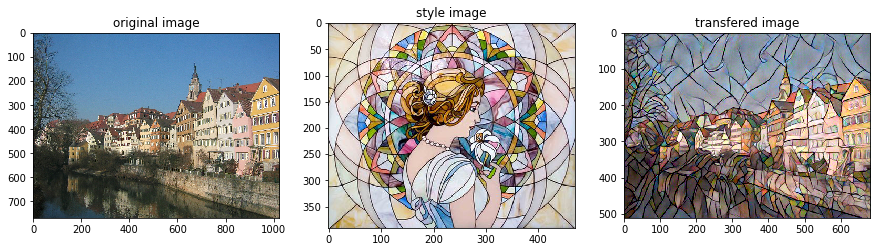

In [21]:
out_img_hr = post(out_img.data[0].cpu().squeeze())

plt.figure(figsize = (15,15))

plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(content_img)
plt.subplot(1,3,2)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,3,3)
plt.title('transfered image')
plt.imshow(out_img_hr)
plt.show()

In [7]:
data_root = "datasets/lab9/train"
image_size = 224
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(data_root, transform)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [17]:
class ImageTransformNet(torch.nn.Module):
    def __init__(self):
        super(ImageTransformNet, self).__init__()
        #############
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,32,9,padding=4, padding_mode='reflect'),
            nn.InstanceNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(64),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1, padding_mode='reflect', stride= 2),
            nn.InstanceNorm2d(128),
            nn.ReLU()
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding = 1, padding_mode='reflect'),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1, padding_mode='reflect'),
            nn.InstanceNorm2d(128)
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding = 1, padding_mode='reflect'),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1, padding_mode='reflect'),
            nn.InstanceNorm2d(128)
        )
        self.res3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding = 1, padding_mode='reflect'),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1, padding_mode='reflect'),
            nn.InstanceNorm2d(128)
        )
        self.res4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding = 1, padding_mode='reflect'),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1, padding_mode='reflect'),
            nn.InstanceNorm2d(128)
        )
        self.res5 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding = 1, padding_mode='reflect'),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1, padding_mode='reflect'),
            nn.InstanceNorm2d(128)
        )
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv4 = nn.Sequential(
            nn.Conv2d(128,64,3,padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(64),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64,32,3,padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(32),
            nn.ReLU()
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(32,3,9,padding=4, padding_mode='reflect'),
        )
        
        #############

    def forward(self, x):
        #############
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.res1(x) + x
        x = self.res2(x) + x
        x = self.res3(x) + x
        x = self.res4(x) + x
        x = self.res5(x) + x
        x = self.up(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        return x
        #############


In [18]:
transformer = ImageTransformNet().cuda()

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReL

In [62]:
style_layer_name = {
   #############
    '4': "relu1-2",
    '9': "relu2-2",
    '16': "relu3-3",
    '23': "relu4-3",
    #############
}

content_layer_name = {
    #############
    '16':"relu4_3"
    #############
}

In [63]:
import torchvision.models.vgg as vgg

class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork, self).__init__()
        # get vgg network
        self.vgg_layers = vgg.vgg16(pretrained=True).features


    def forward(self, x, layer_name):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in layer_name:
                output[layer_name[name]] = x
        return output

In [64]:
loss_net = LossNetwork().cuda()
for param in loss_net.parameters():
    param.requires_grad = False

In [65]:
loss_net

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1

In [66]:
style = transform(style_img).cuda().unsqueeze(0)
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]

In [80]:
# You may adjust hyper paramters 
alpha = 1e0
beta = 1e5
gamma = 1e-7

LR = 1e-3
steps = 2000
criterion = nn.MSELoss()


In [81]:
transformer = ImageTransformNet().cuda()
optimizer = optim.Adam(transformer.parameters(), LR)
transformer.train()
n_iter = 0
class Found(Exception): pass
try:
    while True:
        for x, _ in train_loader:
            #############
            x = x.cuda()
            optimizer = optim.Adam(transformer.parameters(), LR)
            content_gt = [A.detach() for A in loss_net(x, content_layer_name).values()]
            optimizer.zero_grad()
            out = transformer(x)
            style_layers = [gram_matrix(f) for f in loss_net(out, style_layer_name).values()]
            content_layers = [f for f in loss_net(out, content_layer_name).values()]
            style_loss = 0
            style_losses = 0
            for i in range(len(style_layers)):    
                style_loss += criterion(style_layers[i], style_gt[i])
                
        
            content_loss = criterion(content_layers[0], content_gt[0])
            total_variation = (
                torch.sum(torch.abs(out[:,:,:,1:]-out[:,:,:,:-1]))
                + torch.sum(torch.abs(out[:,:,1:,:]-out[:,:,:-1,:]))
            )
            loss = alpha * content_loss + beta * style_loss +gamma*total_variation
            loss.backward()
            n_iter +=1
            #print loss
            if n_iter%50 == 0:
                print('Iteration: {} , total_loss: {:.5f}'.format(n_iter,loss))
                print('style loss: {:.5f} content loss: {:.5f} total variation: {:.5f}'.format(style_loss, content_loss, total_variation))
            optimizer.step()
            
            if n_iter%500 == 0:
                savepath = "we/" +"trans_"+str(n_iter)+".pth"
                torch.save(transformer.state_dict(), savepath)
            
            
            #############
            
            if n_iter >= steps:
                
                
                raise Found

except Found:
    pass
    

Iteration: 50 , total_loss: 1263.88306
style loss: 0.01174 content loss: 89.54240 total variation: 243667.40625
Iteration: 100 , total_loss: 1114.14795
style loss: 0.01017 content loss: 97.29469 total variation: 267639.31250
Iteration: 150 , total_loss: 1033.72742
style loss: 0.00951 content loss: 82.20950 total variation: 250405.31250
Iteration: 200 , total_loss: 912.90295
style loss: 0.00833 content loss: 79.59855 total variation: 225542.29688
Iteration: 250 , total_loss: 693.97620
style loss: 0.00626 content loss: 68.18967 total variation: 215060.37500
Iteration: 300 , total_loss: 775.56049
style loss: 0.00681 content loss: 94.47008 total variation: 276444.06250
Iteration: 350 , total_loss: 821.22363
style loss: 0.00716 content loss: 105.44470 total variation: 274846.37500
Iteration: 400 , total_loss: 629.71936
style loss: 0.00545 content loss: 84.63573 total variation: 262187.56250
Iteration: 450 , total_loss: 466.90820
style loss: 0.00378 content loss: 88.57764 total variation: 25

torch.Size([1, 3, 768, 1024])


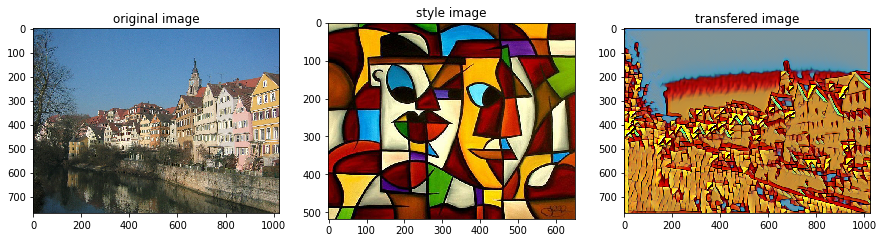

In [88]:
transformer = ImageTransformNet().cuda()
transformer.load_state_dict(torch.load("we/trans_2000.pth"), strict=False)

style_img = Image.open(style_img_name)
content_img = Image.open(content_img_name)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

inverse_transform = transforms.Compose([
    
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                         std=[1/0.229, 1/0.224, 1/0.255]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

#############
transformer.eval()
transformer.cpu()
contents_img = test_transform(content_img).unsqueeze(0)
print(contents_img.size())
out_img = transformer(contents_img)
out_img = inverse_transform(out_img.squeeze())
plt.figure(figsize = (15,15))

plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(content_img)
plt.subplot(1,3,2)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,3,3)
plt.title('transfered image')
plt.imshow(out_img)
plt.show()#############

## Discussion
> Model construct
>> 해당 부분은 큰 어려움이 없었다. 다만 upsample을 해주기 위해서 strided convolution을 진행했어야 했는데 연산의 편의를 위해 conv3 layer에서 strided convolution을 진행하였다.


> loss network
>> 처음에는 vgg19를 인지 못하고 자료를 참조했을 때 4, 9, 16, 23에서 뽑아낸 feature로 style loss를 계산하였는데 total loss를 줄이지 못해서 vgg16으로 바꿔서 실험하였다.


> Hyper parameter setting 
>> 가장 중요하다고 생각한 부분이 alpha랑 beta의 비율이였다. 실제로 2000번 training 기준으로 beta를 1e4에서 1e6사이로 진행하였는데 1e4에서는 style loss가 0.003정도로 부족한 결과를 보였다. 그리고 1e6의 경우 model의 training이 조금 들쭉 날쭉한 경우가 생겼는데 그러한 점 때문에 1e5로 setting하여 training하였고 0.002로 최적화된 값을 보였다.
>> total variance는 각종 reference를 참고했을 때 1e-5~1e-6사이에서 setting하라 되어있었는데 training 시에 너무 많은 영향을 주는 것 같아서 1e-7로 다시 setting해주었다.

>training 
>> mosaic 대신 picasso로 진행하였다. iteration별로 결과는 다음을 통해 확인할 수 있다.iteration이 증가할수록 분리도가 높아지는 것을 확인할 수 있다.

<img src="https://drive.google.com/uc?id=1HJsNDoH0YPXmhj7sGTVBIT8CuaE0V6_Y" alt="no_image" style="width: 700px;"/>